In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import squarify

In [200]:
data = pd.read_csv("datasets/Online Retail.csv")

In [201]:
display(data)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [202]:
data=data[["InvoiceNo","StockCode","Quantity","InvoiceDate","UnitPrice","CustomerID"]].dropna()

data.insert(5, "Total", data["Quantity"]*data["UnitPrice"], True)
data=data[data["Quantity"]>=0]

In [203]:

# customers=data["CustomerID"].unique()

# customer=data[data["CustomerID"]==customers[0]]


# f=open(f'output/{customers[0]}.csv', "w")
# customer.to_csv(path_or_buf=f,index=False,line_terminator='\n')

# f.close()
    

In [204]:
import os
if not os.path.exists('output'):
    os.makedirs('output')

In [205]:
totals={"CustomerID":[],"monetary_vars":[]}
for c in customers:
    customer=data[data["CustomerID"]==c]
    total=customer["Total"].sum()
    totals["CustomerID"].append(c)
    totals["monetary_vars"].append(total)

totals=pd.DataFrame(totals)
f=open(f'output/monetary_vars.csv', "w")
totals.to_csv(path_or_buf=f,index=False,line_terminator='\n')
f.close()

In [206]:
num_invoices={"CustomerID":[],"frequency":[]}

for c in customers:
    customer=data[data["CustomerID"]==c]
    num=len(customer["InvoiceNo"].unique())
    num_invoices["CustomerID"].append(c)
    num_invoices["frequency"].append(num)
num_invoices=pd.DataFrame(num_invoices)
f=open(f'output/frequency.csv', "w")
num_invoices.to_csv(path_or_buf=f,index=False,line_terminator='\n')
f.close()


In [207]:
# recency
from datetime import datetime

unique_dates={"CustomerID":[],"recency":[]}
now=datetime.now()
for c in customers:
    customer=data[data["CustomerID"]==c]
    dates=list(customer["InvoiceDate"].unique())
    dates.sort(key = lambda date: datetime.strptime(date, '%m/%d/%Y %H:%M'))
    date_time_obj = datetime.strptime(dates[len(dates)-1], '%m/%d/%Y %H:%M')

    unique_dates["CustomerID"].append(c)
    unique_dates["recency"].append((now-date_time_obj).days)

unique_dates=pd.DataFrame(unique_dates)
f=open(f'output/recency.csv', "w")
unique_dates.to_csv(path_or_buf=f,index=False,line_terminator='\n')
f.close()


In [208]:
frequency = pd.read_csv("output/frequency.csv")
monetary_vars = pd.read_csv("output/monetary_vars.csv")
recency = pd.read_csv("output/recency.csv")
rfm_values=pd.DataFrame(data={"CustomerID":frequency["CustomerID"],"recency":recency["recency"],'frequency':frequency['frequency'],"monetary":monetary_vars['monetary_vars']})
rfm_values.head()

,CustomerID,recency,frequency,monetary
0,17850.0,3806,34,5391.21
1,13047.0,3466,10,3237.54
2,12583.0,3437,15,7281.38
3,13748.0,3530,5,948.25
4,15100.0,3768,3,876.00


C:\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


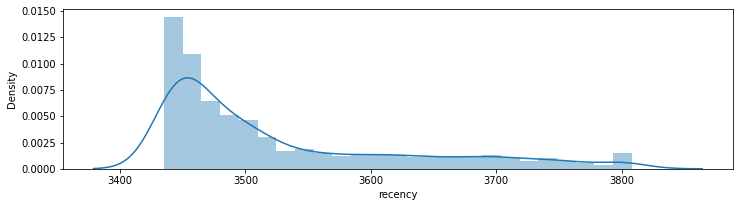

In [209]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_values['recency'])
plt.show()


C:\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


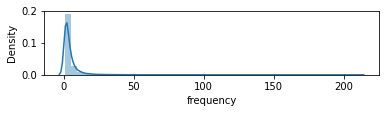

In [210]:
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_values['frequency'])
plt.show()


C:\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


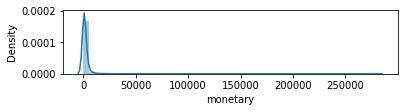

In [211]:
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_values['monetary'])
# Show the plot
plt.show()

In [214]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm_values['recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(rfm_values['frequency'].unique(), q=4, labels=f_labels)
# Create new columns R and F 
data_process = rfm_values.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

NameError: name 'data_process' is not defined